<H3>Global Model-Agnostic Methods</H3>
<p>Global methods describe the average behaviour of a machine learning model. They are often expressed as expected values based on distribution of data</p>
<ul>
    <li>PDP, partial dependence plot is a feature effect method</li>
    <li>the method can be used in both classification and regression problems</li>
    <li><b>PDP assumption</b> is that target feature S is not correlated to any other features in feature space</li>
</ul>
<p>What is partial dependence plot</p>
<ul>
    <li><p>The definition of Partial dependence plot</p>
    <img src='./assets/pics/s81_pdp_def.jpg' alt='Partial dependece plot' width='400'></li>
    <li><p>Empirical calcuation of pdp</p>
    <img src='./assets/pics/s82_pdp_calc.jpg' alt='Calculation' width='200'></li>
</ul>

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lib.process_data import *
from lib.util_ml_helpers import *
from lib.util_xai_plot import *

In [2]:
# set up plotting theme and configurations
#plt.style.available # to find all the style available to matplotlib
plt.style.use('ggplot')
colour_collection = {'orange':"#ff9124", 'blue':"#2492ff"}

<h3>Loading cancer data and classification model</h3>

In [3]:
# loading bike data
cols_cat, cancer_df = process_cancer("./data/cervical.csv")
feature_cols = cols_cat.get("num_std") + cols_cat.get('ordinal')
resp = cols_cat.get('resp')
X = cancer_df[feature_cols].to_numpy()
y = cancer_df[resp].to_numpy()

In [4]:
# loading bike model and fetching predicted value along with bike_df
logistic_model = pickle.load(open("./model/cancer_logistic.sav",'rb'))
gradient_tree_model = pickle.load(open("./model/cancer_boost_tree.sav",'rb'))
outcome_df = pd.DataFrame(data=np.hstack([X
    , y.reshape(-1,1)
    , logistic_model.predict_proba(X).reshape(-1,2)
    , gradient_tree_model.predict_proba(X).reshape(-1,2)
]), columns = feature_cols + ['actual','logistic_prob0', 'logistic_prob1','tree_prob0', 'tree_prob1'])
outcome_df.head(5)

e:\Projects\Envs\Repo\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
e:\Projects\Envs\Repo\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,age_std,num_of_sex_partners_std,first_sex_std,num_of_pregn_std,smokes_yrs_std,hormonal_contrpt_yrs_std,iud_yrs_std,stds_time_since_1diagn_std,stds_time_since_ldiagn_std,smokes,hormonal_contrpt,iud,stds,stds_num,stds_num_diagn,actual,logistic_prob0,logistic_prob1,tree_prob0,tree_prob1
0,0.070423,0.111111,0.227273,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535463,0.464537,0.592939,0.407061
1,0.028169,0.000000,0.181818,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536454,0.463546,0.592939,0.407061
2,0.295775,0.000000,0.227273,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.520965,0.479035,0.556520,0.443480
3,0.549296,0.148148,0.272727,0.363636,1.0,0.1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.506932,0.493068,0.482965,0.517035
4,0.464789,0.074074,0.500000,0.363636,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.462324,0.537676,0.431674,0.568326


In [5]:
# logistic's coef table
feature_df = pd.DataFrame(np.hstack([
    np.array(feature_cols).reshape(-1,1)\
    , logistic_model.coef_.reshape(-1,1)])\
    , columns=['features','coef'])
feature_df

,features,coef
0,age_std,0.2301321484254679
1,num_of_sex_partners_std,-0.056879230749699444
2,first_sex_std,0.01281340928740829
3,num_of_pregn_std,0.11348705272405453
4,smokes_yrs_std,0.14284245661821732
5,hormonal_contrpt_yrs_std,0.827991344737409
6,iud_yrs_std,0.05821189096244198
7,stds_time_since_1diagn_std,-0.0031713766276668144
8,stds_time_since_ldiagn_std,0.04462853879238517
9,smokes,-0.0026893106676068416


<h3>Implement Partial Dependency Plot</h3>
<ol>
    <li>based on its definition. If feature S is the feature of interest, then we average the rest of the feature space to create the function between S and prediction.</li>
    <li>We also will implement a pdpBox version to validate our calculation</li>
</ol>
<p>Reference</p>
<ul>
<li><a href="https://towardsdatascience.com/pitfalls-to-avoid-while-interpreting-machine-learning-pdp-ice-case-c63eeb596590">Avoid PDP pitfalls</a></li>
<li><a href="https://www.kaggle.com/code/satyads/how-not-to-interpret-a-partial-dependence-plot?scriptVersionId=46333836">Kaggle tutorial on PDP</a></li>
<li><a href="https://scikit-learn.org/stable/modules/partial_dependence.html">Scikit-learn Partial Dependence Display</a></li>
</ul>

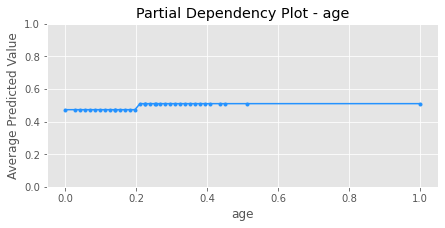

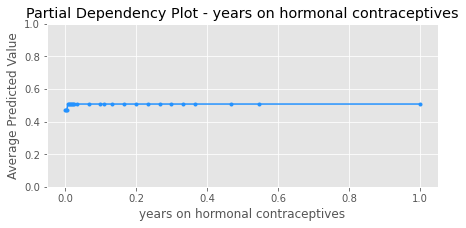

In [6]:
# plotting variables for cancer data
blueprint = {'age':0, 'years on hormonal contraceptives':5}
for k,v in blueprint.items():
    g=plot_pdp(gradient_tree_model,'classification', X, v, var_name = k, ylim=(0,1), n_split=100)
    g.show()

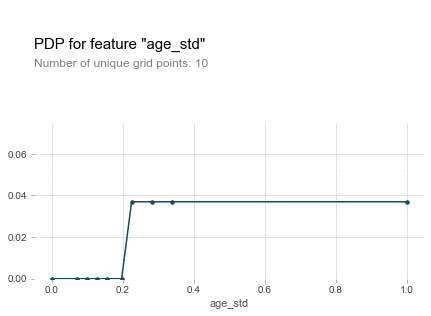

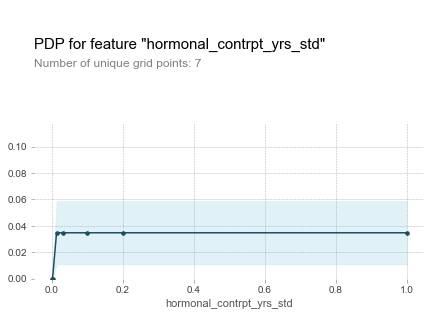

In [7]:
from pdpbox.pdp import pdp_plot, pdp_isolate
for col in ['age_std','hormonal_contrpt_yrs_std']:
    pdp_isolated = pdp_isolate(\
        model = gradient_tree_model\
        , dataset = cancer_df\
        , model_features = feature_cols
        , feature = col)
    fig, axes = pdp_plot(pdp_isolate_out=pdp_isolated, feature_name = col, figsize=(7,5))